 # Title: Pima Indians Diabetes Database
 

1. Relevant Information:
      Several constraints were placed on the selection of these instances from
      a larger database.  In particular, all patients here are females at
      least 21 years old of Pima Indian heritage.  ADAP is an adaptive learning
      routine that generates and executes digital analogs of perceptron-like
      devices.  It is a unique algorithm; see the paper for details.

2. Number of Instances: 768

3. Number of Attributes: 8 plus class 

4. For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

5. Missing Attribute Values: Yes

6. Class Distribution: (class value 1 is interpreted as "tested positive for diabetes")

<table align="left">
    <tr>
   <td>
   Class Value
   </td>
  
   <td>
    Number of instances
   </td>
   </tr>
    <tr>
   <td>
   0
   </td>
  
   <td>
   500
   </td>
   </tr>
   <tr>
   <td>
   1
   </td>
  
   <td>
   268
   </td>
   </tr>
   
   
   </table>

In [1]:
import os
import math
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
 
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)

In [2]:
load_app_config()
DIRECTORY="pima"
FILENAME ='pima-indians-diabetes.data'
RESPONSE="class"
input_path = get_datafolder_path()

{'REG': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'UAT': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'DEV': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'PRD': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}}
Adding F:\MachineLearning  to system path
Adding F:\DataSource  to system path


In [3]:
def load_dataset(filename=FILENAME,response=RESPONSE):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    input_dataset = load_data(input_file)
    print(" input file is :{0} loaded.".format(input_file))
    #print(input_dataset.head())
    
    try:
        continuous_vars = input_dataset.describe().columns
        print("Continous Variables")
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns
        print("Categorical Variables")
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars = None
    
    response_column =  [col for col in input_dataset.columns if response in col]
    feature_columns =  [col for col in input_dataset.columns if response not in col]
            
    
    return  input_dataset,feature_columns,response_column


In [4]:
input_dataset,feature_columns,response_column = load_dataset(filename=FILENAME,response=RESPONSE)
X = input_dataset[feature_columns]
y = input_dataset[response_column]

 input file is :F:\DataSource\pima\pima-indians-diabetes.data loaded.
Continous Variables
Index(['pregnant_times', 'glucose_level', 'blood_pressure', 'triceps',
       'serum_insulin', 'bmi', 'diabetes_function', 'age', 'class'],
      dtype='object')
No categorical variables


In [5]:
def display_data_descriptives(input_dataset,X,feature_columns,y,response_column):
    print("<{0} {1} {0}>".format("="*40,"feature columns"))
    print(feature_columns)
    print("<{0} {1} {0}>".format("="*40,"data header"))
    print(X.head().to_string())
    print("<{0} {1} {0}>".format("="*40,"response"))
    print(response_column)
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -X"))
    print(X.describe())
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -y"))
    print(y.describe())
    print("<{0} {1} {0}>".format("="*40,"value_count -y"))
    print(y['class'].value_counts())
    print("<{0} {1} {0}>".format("="*40,"Correlation"))
    print(input_dataset.corr(method='pearson'))

In [6]:
pd.set_option('display.width', 120)
pd.set_option('precision', 3)
display_data_descriptives(input_dataset,X,feature_columns,y,response_column)

<======================================== feature columns ========================================>
['pregnant_times', 'glucose_level', 'blood_pressure', 'triceps', 'serum_insulin', 'bmi', 'diabetes_function', 'age']
<======================================== data header ========================================>
   pregnant_times  glucose_level  blood_pressure  triceps  serum_insulin   bmi  diabetes_function  age
0               6            148              72       35              0  33.6              0.627   50
1               1             85              66       29              0  26.6              0.351   31
2               8            183              64        0              0  23.3              0.672   32
3               1             89              66       23             94  28.1              0.167   21
4               0            137              40       35            168  43.1              2.288   33
<======================================== response ==================

In [7]:
#, color='cornflowerblue' ,edgecolor='hotpink'
def plot_hist(input_dataset,feature_columns,response_column,nbins=10):
    all_columns= feature_columns+response_column
    fig = plt.figure(figsize=(9,6))
    rows,col = input_dataset.shape
    for i in range(col):
        ax = fig.add_subplot(3, 3, i+1)
        ax.hist(input_dataset[all_columns[i]], bins=10, histtype='stepfilled')
        ax.set_title(all_columns[i])
        
    
    plt.tight_layout()

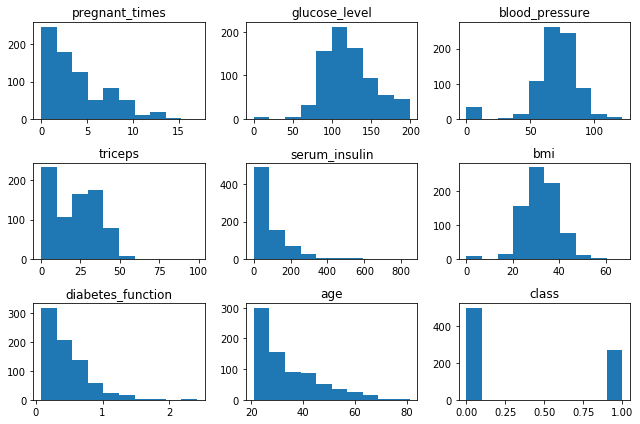

In [8]:
#plt.style.use('seaborn-colorblind')
plot_hist(input_dataset,feature_columns,response_column,10)

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.model_selection  import  train_test_split
from sklearn.linear_model  import LogisticRegression
test_size = 0.33
seed = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)

def evaluvate_pipeline(X_train,y_train):
    
    # create pipeline
    estimators =[]
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('lda', LinearDiscriminantAnalysis()))
    model = Pipeline(estimators)
    # evaluate pipeline
    kfold = KFold(n_splits=10, random_state=7)
    scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold)
    
    return scores,model


In [10]:
scores,pipeline = evaluvate_pipeline(X,y)
print(scores.mean())

0.773462064252


In [11]:
pipeline.fit(X_train,y_train.values.ravel())

Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))])

In [12]:
from sklearn import metrics
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)),"\n" )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred),"\n")
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),"\n")
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)),"\n")
    return y_pred

In [13]:
y_pred = measure_performance(X_test,y_test,pipeline, show_accuracy=True, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

Accuracy:0.772 

Classification report
             precision    recall  f1-score   support

          0       0.80      0.86      0.83       162
          1       0.72      0.61      0.66        92

avg / total       0.77      0.77      0.77       254
 

Confusion matrix
[[140  22]
 [ 36  56]] 



In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

from matplotlib import style

style.use('seaborn-colorblind')

def plot_roc(y_test, y_pred):
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    fig = plt.figure(figsize=(6,4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    roc_auc_score(y_test, y_pred)



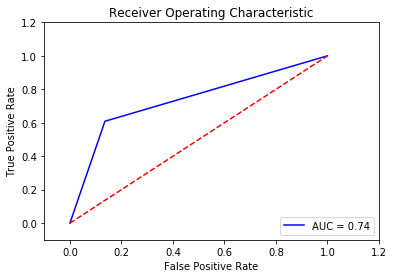

In [15]:
plot_roc(y_test, y_pred)

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction

def select_features_by_XTree(X,y):
    model = ExtraTreesClassifier()
    model.fit(X, y.values.ravel())

    selected_features =np.array(model.feature_importances_)
    selected_features_X = pd.DataFrame(X.columns.values, columns=['name'])
    selected_features =selected_features.reshape(8,1)

    selected_features_X['model_result'] =selected_features
    selected_features_X =selected_features_X.sort_values(by='model_result',ascending=False)
    return selected_features_X

In [17]:
features_XTree = select_features_by_XTree(X,y)
top_features =features_XTree['name']
top_features =list(top_features.values)
top_features[0:5]

['glucose_level', 'bmi', 'age', 'diabetes_function', 'pregnant_times']

0.768288084465
Accuracy:0.772 

Classification report
             precision    recall  f1-score   support

          0       0.80      0.86      0.83       162
          1       0.72      0.61      0.66        92

avg / total       0.77      0.77      0.77       254
 

Confusion matrix
[[140  22]
 [ 36  56]] 



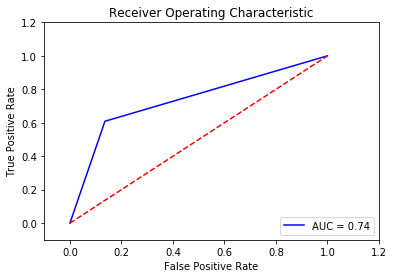

In [18]:
X = input_dataset[top_features]
y = input_dataset[response_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)
scores,model = evaluvate_pipeline(X_train,y_train)
print(scores.mean())
model.fit(X_train,y_train.values.ravel())
y_pred = measure_performance(X_test,y_test,model, show_accuracy=True, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)
plot_roc(y_test, y_pred)